In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from os.path import join as pjoin
from scipy.spatial.distance import pdist
from sklearn import neighbors
from scipy.io import loadmat
from scipy.stats import zscore 
from sklearn.datasets import load_digits

from sklearn.decomposition import PCA,KernelPCA
import umap

# sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


In [4]:
# Calculatory functions
def var_expl(X,Y):
    """
        Calculate proportion variance in X explained by variance in Y
    """
    X = X - np.mean(X,1)[:,np.newaxis]
    Y = Y - np.mean(Y,1)[:,np.newaxis]
    X_2 = np.mean(np.linalg.norm(X,2,axis = 1))**2
    X_minus_Y_2 = np.mean(np.linalg.norm(X - Y,2,axis = 1))**2
    return (X_2 - X_minus_Y_2) / X_2

In [82]:
# Visualization functions
def rxnil_dynamics_plot1(X,tts,colors,pre_cue_ix,median_cue_len,post_leave_ix):
    """
        Plot RXNil Dynamics in 1D
    """
    for tt in tts: 
        # pre-cue
        plt.plot(np.arange(pre_cue_ix),X[tt][:pre_cue_ix],linewidth = 2,color = [.5 ,.5, .5]) 
        # cue
        plt.plot(np.arange(pre_cue_ix,pre_cue_ix + median_cue_len),X[tt][pre_cue_ix:pre_cue_ix + median_cue_len],linewidth = 2,color = [.2, .7, .2]) 
        # trial 
        in_trial_ix = len(X[tt][pre_cue_ix + median_cue_len:-post_leave_ix])
        plt.plot(pre_cue_ix + median_cue_len + np.arange(in_trial_ix),X[tt][pre_cue_ix + median_cue_len:-post_leave_ix],color = colors[tt],linewidth = 2) 

        tick_interval = 10;  
        tt_len = len(X[tt][pre_cue_ix + median_cue_len:-post_leave_ix]);

        # add time ticks for cue
        time_ticks = np.arange((pre_cue_ix+tick_interval),(pre_cue_ix + median_cue_len - tick_interval),tick_interval);
        plt.plot(time_ticks,X[tt][time_ticks],
              marker = 'o',markerSize = 8, markerFaceColor = [.2, .7, .2],markerEdgeColor = 'k',linestyle =''); 
        # add time ticks for on patch
        time_ticks = np.arange(((pre_cue_ix + median_cue_len)+tick_interval),((pre_cue_ix + median_cue_len)+tt_len - tick_interval),tick_interval);
        plt.plot(time_ticks,X[tt][time_ticks],
              marker = 'o', markerSize = 8, markerFaceColor = colors[tt],markerEdgeColor = 'k',linestyle =''); 

        # add mark for reward
        if np.mod(tt,2) == 1:
            plt.plot((pre_cue_ix + median_cue_len)+50,X[tt][(pre_cue_ix + median_cue_len)+50],  
                  marker = 'd', markerSize = 15, markerFaceColor = colors[tt],markerEdgeColor = 'k',linestyle ='')

        # add some marks to make the trajectories more interpretable 
        plt.plot(0,X[tt][0],marker = 'o', markerSize = 15, markerFaceColor = [.5, .5, .5],markerEdgeColor = 'k',linestyle ='');
        plt.plot(pre_cue_ix,X[tt][pre_cue_ix],marker ='o', markerSize = 15, 
             markerFaceColor = [.2,.7,.2],markerEdgeColor = 'k',linestyle ='');  

        # add O at start of trial
        plt.plot(pre_cue_ix + median_cue_len,X[tt][pre_cue_ix + median_cue_len],
              marker = 'o', markerSize = 15, markerFaceColor = colors[tt],markerEdgeColor = 'k',linestyle ='');
        # add X at end of trial
        plt.plot(len(X[tt]) - post_leave_ix,X[tt][-post_leave_ix],
              marker = 'o', markerSize = 15, markerFaceColor = colors[tt],markerEdgeColor = 'k',linestyle ='');
        # add X at end of trial
        plt.plot(len(X[tt]) - post_leave_ix,X[tt][-post_leave_ix], marker = 'x', markerSize = 15, 
             markerFaceColor = [.5, .5, .5],linewidth = 2,markerEdgeColor = 'k',linestyle ='');

def rxnil_dynamics_plot2(X,tts,colors,pre_cue_ix,median_cue_len,post_leave_ix):
    """
        Plot RXNil Dynamics in 2D
    """
    for tt in tts: 
        # pre-cue
        plt.plot(X[tt][0,:pre_cue_ix],X[tt][1,:pre_cue_ix],linewidth = 2,color = [.5 ,.5, .5]) 
        # cue
        plt.plot(X[tt][0,pre_cue_ix:pre_cue_ix + median_cue_len],X[tt][1,pre_cue_ix:pre_cue_ix + median_cue_len],linewidth = 2,color = [.2, .7, .2]) 
        # trial 
        in_trial_ix = len(X[tt][pre_cue_ix + median_cue_len:-post_leave_ix])
        plt.plot(X[tt][0,pre_cue_ix + median_cue_len:-post_leave_ix],X[tt][1,pre_cue_ix + median_cue_len:-post_leave_ix],color = colors[tt],linewidth = 2) 

        tick_interval = 10;  
        tt_len = len(X[tt][0,pre_cue_ix + median_cue_len:-post_leave_ix]);

        # add time ticks for cue
        time_ticks = np.arange((pre_cue_ix+tick_interval),(pre_cue_ix + median_cue_len - tick_interval),tick_interval);
        plt.plot(X[tt][0,time_ticks],X[tt][1,time_ticks],
              marker = 'o',markerSize = 8, markerFaceColor = [.2, .7, .2],markerEdgeColor = 'k',linestyle =''); 
        # add time ticks for on patch
        time_ticks = np.arange(((pre_cue_ix + median_cue_len)+tick_interval),((pre_cue_ix + median_cue_len)+tt_len - tick_interval),tick_interval);
        plt.plot(X[tt][0,time_ticks],X[tt][1,time_ticks],
              marker = 'o', markerSize = 8, markerFaceColor = colors[tt],markerEdgeColor = 'k',linestyle =''); 

        # add mark for reward
        if np.mod(tt,2) == 1:
            plt.plot(X[tt][0,(pre_cue_ix + median_cue_len)+50],X[tt][1,(pre_cue_ix + median_cue_len)+50],  
                  marker = 'd', markerSize = 15, markerFaceColor = colors[tt],markerEdgeColor = 'k',linestyle ='')

        # add some marks to make the trajectories more interpretable 
        plt.plot(X[tt][0,0],X[tt][1,0],marker = 'o', markerSize = 15, markerFaceColor = [.5, .5, .5],markerEdgeColor = 'k',linestyle ='');
        plt.plot(X[tt][0,pre_cue_ix],X[tt][1,pre_cue_ix],marker ='o', markerSize = 15, 
             markerFaceColor = [.2,.7,.2],markerEdgeColor = 'k',linestyle ='');  

        # add O at start of trial
        plt.plot(X[tt][0,pre_cue_ix + median_cue_len],X[tt][1,pre_cue_ix + median_cue_len],
              marker = 'o', markerSize = 15, markerFaceColor = colors[tt],markerEdgeColor = 'k',linestyle ='');
        # add X at end of trial
        plt.plot(X[tt][0,-post_leave_ix],X[tt][1,-post_leave_ix],
              marker = 'o', markerSize = 15, markerFaceColor = colors[tt],markerEdgeColor = 'k',linestyle ='');
        # add X at end of trial
        plt.plot(X[tt][0,-post_leave_ix],X[tt][1,-post_leave_ix], marker = 'x', markerSize = 15, 
             markerFaceColor = [.5, .5, .5],linewidth = 2,markerEdgeColor = 'k',linestyle ='');



In [6]:
# Data paths
manifold_data_path = '/Users/joshstern/Documents/UchidaLab_NeuralData/patch_foraging_neuropix/josh/manifolds/spud_code/data'
rxnil_data_path = pjoin(manifold_data_path,'rxnil_data.mat')


In [78]:
# Load data
rxnil_data = loadmat(rxnil_data_path)
rxnil_mean_full = rxnil_data['glmPFC_RXNil_mean_full']
tt_starts = rxnil_data['tt_starts'][0]
X = rxnil_mean_full.T
X = zscore(X)
n_timepoints,n_neurons = X.shape
print(X.shape)

(1477, 578)


In [90]:
# Check out 1D
n_components = 1
pca_transformer = PCA(n_components = n_components)
X_transformed_pca = pca_transformer.fit_transform(X)

# Play around w/ n_neighbors and min_dist to make this nicer!
umap_transformer = umap.UMAP(n_components = n_components,n_neighbors = 200,min_dist = .9,transform_seed=5)
X_transformed_umap = umap_transformer.fit_transform(X)


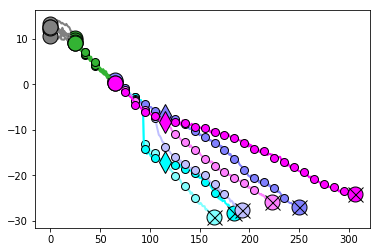

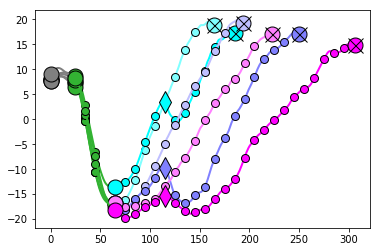

In [91]:
# squid plot 1D
pre_cue_ix = 25
post_leave_ix = 25
median_cue_len = 40
colors = {0 : [.5,1,1], 1: [0,1,1], 2: [.75,.75,1], 3: [.5,.5,1], 4: [1,.5,1], 5: [1,0,1]}
tts = np.arange(6)
X_pca_tts = {}
X_umap_tts = {}
for tt in tts:
    X_umap_tts[tt] = X_transformed_umap[tt_starts[tt]+1:tt_starts[tt+1]]
    X_pca_tts[tt] = X_transformed_pca[tt_starts[tt]+1:tt_starts[tt+1]]

    
plt.figure()
rxnil_dynamics_plot1(X_umap_tts,tts,colors,pre_cue_ix,median_cue_len,post_leave_ix)
plt.figure()
rxnil_dynamics_plot1(X_pca_tts,tts,colors,pre_cue_ix,median_cue_len,post_leave_ix)


In [105]:
# Now try 2D
n_components = 2
pca_transformer = PCA(n_components = n_components)
X_transformed_pca = pca_transformer.fit_transform(X)

# Play around w/ n_neighbors and min_dist to make this nicer!
umap_transformer = umap.UMAP(n_components = n_components,n_neighbors = 200,min_dist = .99,transform_seed=42)
X_transformed_umap = umap_transformer.fit_transform(X)


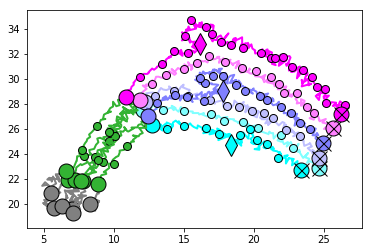

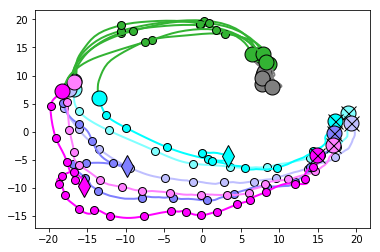

In [106]:
tts = np.arange(6)
X_pca_tts = {}
X_umap_tts = {}
for tt in tts:
    X_umap_tts[tt] = X_transformed_umap[tt_starts[tt]+1:tt_starts[tt+1],:].T
    X_pca_tts[tt] = X_transformed_pca[tt_starts[tt]+1:tt_starts[tt+1],:].T

    
plt.figure()
rxnil_dynamics_plot2(X_umap_tts,tts,colors,pre_cue_ix,median_cue_len,post_leave_ix)
plt.figure()
rxnil_dynamics_plot2(X_pca_tts,tts,colors,pre_cue_ix,median_cue_len,post_leave_ix)

In [97]:
# Now check out variance explained
# first PCA
pca_expl_var = []
for n_components in range(2,4):
    pca_transformer = PCA(n_components = n_components)
    X_transformed_pca = pca_transformer.fit_transform(X)
    X_reconstr_pca = pca_transformer.inverse_transform(X_transformed_pca)
    this_var_expl = var_expl(X,X_reconstr_pca)
    pca_expl_var.append(this_var_expl)

umap_expl_var = []
for n_components in range(2,4):
    umap_transformer = umap.UMAP(n_components = n_components,n_neighbors = 200,min_dist = 0.9,transform_seed=42)
    X_transformed_umap = umap_transformer.fit_transform(X)
    print("%i components finished transform"%n_components)
    X_reconstr_umap = umap_transformer.inverse_transform(X_transformed_umap)
    this_var_expl = var_expl(X,X_reconstr_umap)
    
    umap_expl_var.append(this_var_expl)
    print("%i components %.5f var_expl"%(n_components,this_var_expl))

2 components finished transform
2 components -0.14312 var_expl
3 components finished transform
3 components -0.26084 var_expl


In [107]:
X_reconstr_umap = umap_transformer.inverse_transform(X_transformed_umap)
this_var_expl = var_expl(X,X_reconstr_umap)


In [108]:
print(this_var_expl)

-0.15781128605545347
